# Plot of the Week: Train vs Validation Loss Curves (Overfitting)

**Goal.** Fit a **nonlinear regression** model and plot **train vs validation loss vs epoch** to diagnose **overfitting**.

Students will **modify one element** (model size, regularization, optimizer hyperparameters, dataset size/noise, etc.) to **prevent overfitting**.

---

## What question does this plot answer?
How do the model’s training and validation losses evolve during training, and **does the gap indicate overfitting**?

## Why is it important?
Loss curves are a fast, reliable diagnostic for:
- **Overfitting vs underfitting**
- **Optimization stability** (learning rate too high/low, divergence, plateaus)
- **Experiment tracking** (comparing runs and hyperparameters)


In [69]:
# If you're running this on Colab, you might need:
# !pip install torch --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1) Create a simple nonlinear regression dataset (simulated)

We’ll learn a noisy nonlinear function (a sinusoid with noise).
To make overfitting **easy to observe**, we use:
- relatively **small training set**
- a **high-capacity** model later


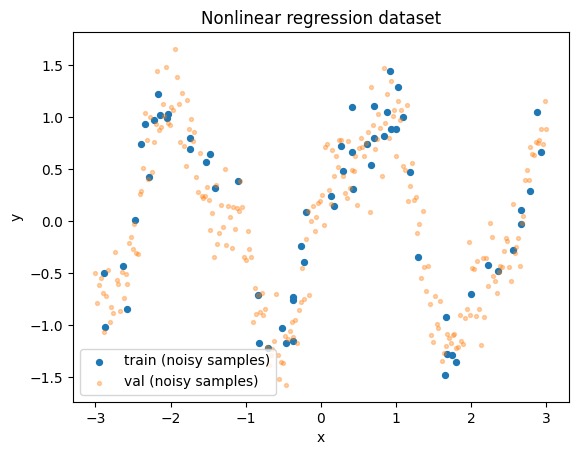

In [70]:
def make_sine_data(n_train=64, n_val=256, noise_std=0.25, x_range=(-3.0, 3.0)):
    # Train points
    x_train = np.random.uniform(x_range[0], x_range[1], size=(n_train, 1)).astype(np.float32)
    y_train = (np.sin(2.5 * x_train) + 0.3*np.cos(6 * x_train) + noise_std*np.random.randn(n_train, 1)).astype(np.float32)

    # Validation points (denser grid)
    x_val = np.linspace(x_range[0], x_range[1], n_val).reshape(-1, 1).astype(np.float32)
    y_val = (np.sin(2.5 * x_val) + 0.3*np.cos(6 * x_val) + noise_std*np.random.randn(n_val, 1)).astype(np.float32)
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = make_sine_data()

plt.figure()
plt.scatter(x_train, y_train, s=18, label="train (noisy samples)")
plt.scatter(x_val, y_val, s=8, alpha=0.35, label="val (noisy samples)")
plt.title("Nonlinear regression dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 2) Define a nonlinear regression model (MLP)

This MLP can easily **overfit** if:
- too many hidden units/layers
- training too long
- weak/no regularization

**Student knobs** (change these later): `hidden_dim`, `depth`, `dropout`, `weight_decay`.


In [71]:
class MLPRegressor(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=256, depth=4, dropout=0.0):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden_dim))
            layers.append(nn.Tanh())  # smooth nonlinearity works well for this toy regression
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = hidden_dim
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Baseline model (intentionally high-capacity to provoke overfitting)
model = MLPRegressor(hidden_dim=256, depth=4, dropout=0.0).to(device)
sum(p.numel() for p in model.parameters())

198145

## 3) Training loop with logging

We log:
- training loss per epoch
- validation loss per epoch

and then plot them.

**Student knobs**: `lr`, `weight_decay`, `batch_size`, `epochs`.


In [72]:
def train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
    print_every=50,
):
    # Data
    train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

    # Loss + optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total = 0.0
        n = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)
        train_loss = total / n

        # ---- val ----
        model.eval()
        total = 0.0
        n = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
                n += xb.size(0)
        val_loss = total / n

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if print_every and (epoch % print_every == 0 or epoch == 1 or epoch == epochs):
            print(f"epoch {epoch:4d} | train MSE {train_loss:.4f} | val MSE {val_loss:.4f}")

    return np.array(train_losses), np.array(val_losses)

# Run a baseline that often overfits
model = MLPRegressor(hidden_dim=256, depth=4, dropout=0.0).to(device)

train_losses, val_losses = train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
    print_every=60,
)

epoch    1 | train MSE 1.7484 | val MSE 0.9339
epoch   60 | train MSE 0.2001 | val MSE 0.2398
epoch  120 | train MSE 0.0605 | val MSE 0.0987
epoch  180 | train MSE 0.0482 | val MSE 0.1132
epoch  240 | train MSE 0.0448 | val MSE 0.0876
epoch  300 | train MSE 0.0362 | val MSE 0.0849


## 4) Plot 1: Train vs Validation Loss Curves (minimum requirement)

**Interpretation tip:**  
Overfitting often looks like:
- train loss keeps decreasing
- validation loss bottoms out then starts increasing (or stops improving)



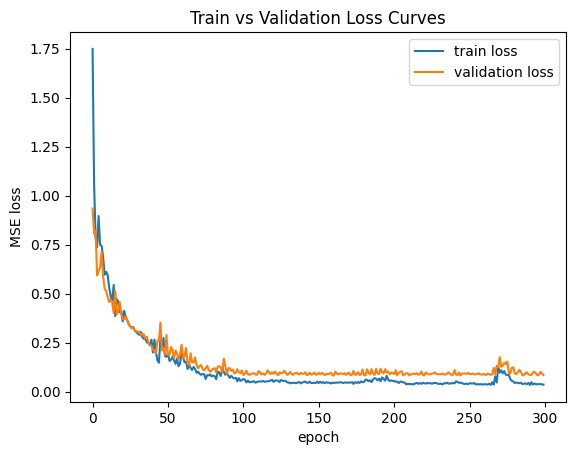

Best validation loss at epoch: 161 val_loss: 0.08291959762573242


In [73]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Train vs Validation Loss Curves")
plt.legend()
plt.show()

# Optional: print epoch of best validation performance
best_epoch = int(val_losses.argmin()) + 1
print("Best validation loss at epoch:", best_epoch, "val_loss:", float(val_losses.min()))

## 5) Visualize the fitted function (helps explain overfitting)

This is optional but often makes the story clearer.


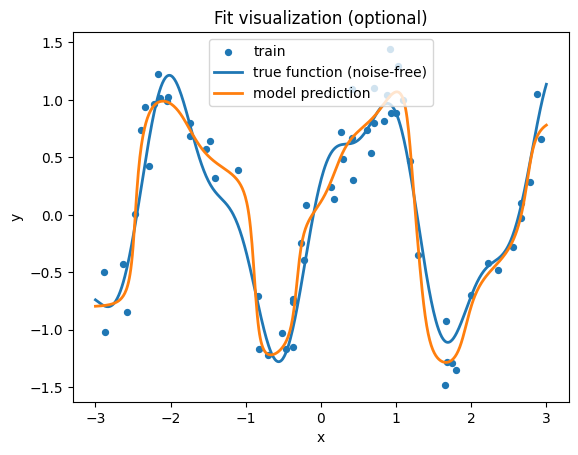

In [74]:
# Predict on a dense grid
model.eval()
x_grid = np.linspace(-3, 3, 600).reshape(-1, 1).astype(np.float32)
with torch.no_grad():
    y_pred = model(torch.from_numpy(x_grid).to(device)).cpu().numpy()

plt.figure()
plt.scatter(x_train, y_train, s=18, label="train")
plt.plot(x_grid, np.sin(2.5*x_grid) + 0.3*np.cos(6*x_grid), linewidth=2, label="true function (noise-free)")
plt.plot(x_grid, y_pred, linewidth=2, label="model prediction")
plt.title("Fit visualization (optional)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 6) Student task: prevent overfitting

**Choose ONE change** and re-run the training cell(s). Then submit your updated **loss curve plot**.

### Suggested edits (pick one)
1. **Regularization**  
   - increase `weight_decay` (e.g., `1e-4`, `1e-3`, `1e-2`)  
   - add `dropout` (e.g., `0.1`–`0.3`)  
2. **Reduce model capacity**  
   - lower `hidden_dim` (e.g., `32`, `64`)  
   - reduce `depth` (e.g., `2`)  
3. **Train less / early stopping (simple version)**  
   - reduce `epochs`  
   - stop training near the best validation epoch  
4. **More data / less noise**  
   - increase `n_train` (e.g., `256`)  
   - reduce `noise_std` (e.g., `0.10`)  
5. **Optimizer dynamics**  
   - change `lr` (try `1e-3` or `1e-4`)  
   - change `batch_size`

### What “success” looks like
A run where **validation loss does not rise** (or rises much less), and the **train–val gap** is smaller.

---

## Required Submission Template

**Upload**:

the figure (PNG or PDF)

OR the notebook cell output

Short caption (1–2 sentences)

**Title:**  
Train vs Validation Loss Curves

**What question does this plot answer?**  
(1 sentence.)

**Description (1–2 sentences):**  
What data / model / comparison is shown?  
What change did you make, and what happened?



### Starter cell for experiments (students edit this)

Edit the hyperparameters below, re-run, and regenerate **Plot 1**.


epoch    1 | train MSE 1.4605 | val MSE 1.6350
epoch   60 | train MSE 0.1273 | val MSE 0.1879
epoch  120 | train MSE 0.0627 | val MSE 0.0813
epoch  180 | train MSE 0.0478 | val MSE 0.0690
epoch  240 | train MSE 0.0413 | val MSE 0.0699
epoch  250 | train MSE 0.0523 | val MSE 0.0780


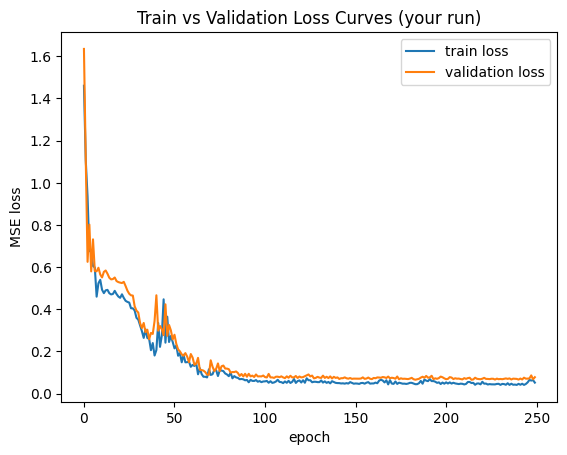

Best validation loss at epoch: 215 val_loss: 0.06586755067110062


In [82]:
# =========================
# STUDENTS: EDIT THESE
# =========================
n_train = 64
noise_std = 0.25

hidden_dim = 256
depth = 4
dropout = 0.

# Weight Decay: 1e-4, 1e-3, 1e-2
# Dropout: 0.1, 0.2, 0.3

lr = 3e-3
weight_decay = 0.
batch_size = 32
epochs = 250

# Recreate data + model, then train
x_train, y_train, x_val, y_val = make_sine_data(n_train=n_train, noise_std=noise_std)
model = MLPRegressor(hidden_dim=hidden_dim, depth=depth, dropout=dropout).to(device)

train_losses, val_losses = train_one_run(
    model,
    x_train, y_train, x_val, y_val,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    epochs=epochs,
    print_every=60,
)

# Plot 1 (required)
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Train vs Validation Loss Curves (your run)")
plt.legend()
plt.show()

best_epoch = int(val_losses.argmin()) + 1
print("Best validation loss at epoch:", best_epoch, "val_loss:", float(val_losses.min()))

=== Baseline (default params) ===
epoch    1 | train MSE 1.7695 | val MSE 0.9691
epoch   60 | train MSE 0.1010 | val MSE 0.1006
epoch  120 | train MSE 0.0570 | val MSE 0.0839
epoch  180 | train MSE 0.0528 | val MSE 0.0726
epoch  240 | train MSE 0.0417 | val MSE 0.0677
epoch  300 | train MSE 0.0527 | val MSE 0.0688
BASELINE best_epoch=270 best_val=0.064454 gap=0.024909

=== All runs (sorted) ===


,tag,epochs,best_epoch,best_val,gap_at_best,final_val
0,early_stop: epochs=300,300,270,0.064454,0.024909,0.068792
1,early_stop: epochs=250,250,238,0.065876,0.023551,0.066484
2,early_stop: epochs=200,200,173,0.066965,0.018395,0.069660
3,early_stop: epochs=150,150,145,0.070617,0.017999,0.072726
4,early_stop: epochs=100,100,97,0.073118,0.014050,0.075355
5,early_stop: epochs=75,75,73,0.079210,0.017690,0.082766



=== BEST NON-DEFAULT CONFIG (to submit) ===
early_stop: epochs=250
best_epoch=238 best_val=0.065876 gap=0.023551


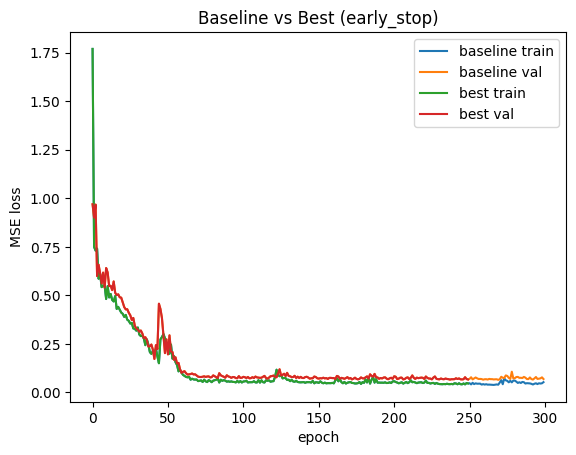

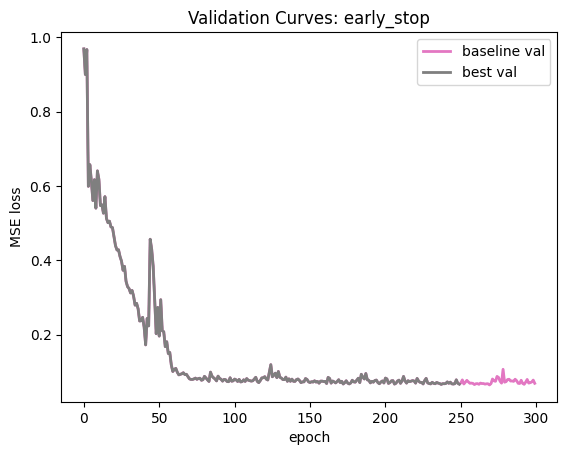

In [83]:
"""
sweep_overfitting_one_strategy.py

Run a sweep for ONE "overfitting prevention" strategy at a time, and pick the best non-default config.

Usage (in notebook):
1) Make sure make_sine_data, MLPRegressor, train_one_run, device are already defined/imported.
2) Adjust BASE_PARAMS to match your notebook defaults.
3) Set STRATEGY = "regularization" (or other).
4) Run this file (or paste into a cell).

Strategies:
- "regularization": sweep dropout x weight_decay
- "capacity": sweep hidden_dim x depth
- "early_stop": sweep epochs (simple)
- "data": sweep n_train and/or noise_std
- "optimizer": sweep lr x batch_size
"""

from __future__ import annotations

import itertools
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# =========================
# CHOOSE ONE STRATEGY HERE
# =========================
# STRATEGY = "regularization"
# STRATEGY = "capacity"
STRATEGY = "early_stop"
# STRATEGY = "data"
# STRATEGY = "optimizer"


# =========================
# SET YOUR DEFAULTS HERE
# (match the notebook cell)
# =========================
SEED = 42

BASE_PARAMS = dict(
    n_train=64,
    noise_std=0.25,
    hidden_dim=256,
    depth=4,
    dropout=0.0,
    lr=3e-3,
    weight_decay=0.0,
    batch_size=32,
    epochs=300,
)

# If you want to treat your baseline as "the notebook default",
# leave these alone. We will ALWAYS include a baseline run and
# then pick the best NON-BASELINE config.


def _set_seeds(seed: int = SEED) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def _run_one(config: Dict[str, Any], x_train, y_train, x_val, y_val, print_every: int = 0) -> Dict[str, Any]:
    """
    Train one model run and return metrics + curves.
    Requires: MLPRegressor, train_one_run, device exist in global scope (from your notebook).
    """
    _set_seeds(SEED)

    model = MLPRegressor(
        hidden_dim=int(config["hidden_dim"]),
        depth=int(config["depth"]),
        dropout=float(config["dropout"]),
    ).to(device)

    train_losses, val_losses = train_one_run(
        model,
        x_train, y_train, x_val, y_val,
        lr=float(config["lr"]),
        weight_decay=float(config["weight_decay"]),
        batch_size=int(config["batch_size"]),
        epochs=int(config["epochs"]),
        print_every=print_every,
    )

    train_losses = np.array(train_losses, dtype=float)
    val_losses = np.array(val_losses, dtype=float)

    best_idx = int(val_losses.argmin())
    best_epoch = best_idx + 1

    out = dict(config)
    out.update(
        best_epoch=best_epoch,
        best_val=float(val_losses[best_idx]),
        train_at_best=float(train_losses[best_idx]),
        gap_at_best=float(val_losses[best_idx] - train_losses[best_idx]),
        final_train=float(train_losses[-1]),
        final_val=float(val_losses[-1]),
        train_losses=train_losses,
        val_losses=val_losses,
    )
    return out


def _configs_for_strategy(strategy: str, base: Dict[str, Any]) -> Tuple[List[Dict[str, Any]], List[str]]:
    """
    Returns (configs, columns_to_display)
    Each config is a full param dict ready to train.
    """
    configs: List[Dict[str, Any]] = []

    if strategy == "regularization":
        dropout_grid = [0.0, 0.1, 0.2, 0.3]
        weight_decay_grid = [0.0, 1e-4, 1e-3, 1e-2]
        for d, wd in itertools.product(dropout_grid, weight_decay_grid):
            cfg = dict(base)
            cfg["dropout"] = d
            cfg["weight_decay"] = wd
            cfg["tag"] = f"regularization: dropout={d}, wd={wd:g}"
            configs.append(cfg)

        cols = ["dropout", "weight_decay", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "capacity":
        hidden_dim_grid = [256, 128, 64, 32]  # include base + smaller
        depth_grid = [4, 3, 2]                # include base + smaller
        for h, dep in itertools.product(hidden_dim_grid, depth_grid):
            cfg = dict(base)
            cfg["hidden_dim"] = h
            cfg["depth"] = dep
            cfg["tag"] = f"capacity: hidden_dim={h}, depth={dep}"
            configs.append(cfg)

        cols = ["hidden_dim", "depth", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "early_stop":
        # "Train less / early stopping (simple version)" = reduce epochs
        # Try a handful; base is 300 so include smaller.
        epochs_grid = [300, 250, 200, 150, 100, 75]
        for e in epochs_grid:
            cfg = dict(base)
            cfg["epochs"] = e
            cfg["tag"] = f"early_stop: epochs={e}"
            configs.append(cfg)

        cols = ["epochs", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "data":
        # "More data / less noise": increase n_train OR reduce noise_std
        # This is still "one strategy", but it includes a combo grid.
        n_train_grid = [64, 128, 256]
        noise_grid = [0.25, 0.20, 0.10]
        for n, ns in itertools.product(n_train_grid, noise_grid):
            cfg = dict(base)
            cfg["n_train"] = n
            cfg["noise_std"] = ns
            cfg["tag"] = f"data: n_train={n}, noise_std={ns}"
            configs.append(cfg)

        cols = ["n_train", "noise_std", "best_epoch", "best_val", "gap_at_best", "final_val"]

    elif strategy == "optimizer":
        lr_grid = [3e-3, 1e-3, 3e-4, 1e-4]
        batch_grid = [32, 64,	controller := 128]  # include bigger batches
        # NOTE: if 128 is too slow, remove it.
        for lr, bs in itertools.product(lr_grid, batch_grid):
            cfg = dict(base)
            cfg["lr"] = lr
            cfg["batch_size"] = bs
            cfg["tag"] = f"optimizer: lr={lr:g}, batch_size={bs}"
            configs.append(cfg)

        cols = ["lr", "batch_size", "best_epoch", "best_val", "gap_at_best", "final_val"]

    else:
        raise ValueError(f"Unknown STRATEGY={strategy}")

    return configs, cols


def main():
    _set_seeds(SEED)

    # Always run baseline on the BASE_PARAMS
    print("=== Baseline (default params) ===")

    # IMPORTANT: dataset depends on n_train/noise_std, so we generate it per-config
    # for strategies that change data. For the other strategies, we reuse a fixed dataset.
    changes_data = STRATEGY == "data"

    # Baseline dataset
    x_train0, y_train0, x_val0, y_val0 = make_sine_data(
        n_train=int(BASE_PARAMS["n_train"]),
        noise_std=float(BASE_PARAMS["noise_std"]),
    )

    baseline = _run_one(dict(BASE_PARAMS, tag="BASELINE"), x_train0, y_train0, x_val0, y_val0, print_every=60)
    print(f"BASELINE best_epoch={baseline['best_epoch']} best_val={baseline['best_val']:.6f} gap={baseline['gap_at_best']:.6f}")

    # Build configs for selected strategy
    configs, display_cols = _configs_for_strategy(STRATEGY, BASE_PARAMS)

    results = []
    for cfg in configs:
        if changes_data:
            # regenerate dataset for each config (because n_train/noise_std changes)
            x_train, y_train, x_val, y_val = make_sine_data(
                n_train=int(cfg["n_train"]),
                noise_std=float(cfg["noise_std"]),
            )
        else:
            x_train, y_train, x_val, y_val = x_train0, y_train0, x_val0, y_val0

        res = _run_one(cfg, x_train, y_train, x_val, y_val, print_every=0)
        results.append(res)

    # Build dataframe (without big arrays)
    df = pd.DataFrame([{
        **{k: r.get(k) for k in ["tag", "n_train", "noise_std", "hidden_dim", "depth", "dropout", "lr", "weight_decay", "batch_size", "epochs"]},
        "best_epoch": r["best_epoch"],
        "best_val": r["best_val"],
        "gap_at_best": r["gap_at_best"],
        "final_val": r["final_val"],
    } for r in results])

    # Sort (primary: best_val, secondary: gap)
    df_sorted = df.sort_values(["best_val", "gap_at_best"], ascending=[True, True]).reset_index(drop=True)

    print("\n=== All runs (sorted) ===")
    cols_to_show = [c for c in ["tag"] + display_cols if c in df_sorted.columns]
    display(df_sorted[cols_to_show])

    # Pick best NON-BASELINE (i.e., differs from BASE_PARAMS in at least one strategy-relevant param)
    def is_non_default(row) -> bool:
        # Compare only relevant knobs for chosen strategy
        if STRATEGY == "regularization":
            return not (float(row["dropout"]) == float(BASE_PARAMS["dropout"]) and float(row["weight_decay"]) == float(BASE_PARAMS["weight_decay"]))
        if STRATEGY == "capacity":
            return not (int(row["hidden_dim"]) == int(BASE_PARAMS["hidden_dim"]) and int(row["depth"]) == int(BASE_PARAMS["depth"]))
        if STRATEGY == "early_stop":
            return not (int(row["epochs"]) == int(BASE_PARAMS["epochs"]))
        if STRATEGY == "data":
            return not (int(row["n_train"]) == int(BASE_PARAMS["n_train"]) and float(row["noise_std"]) == float(BASE_PARAMS["noise_std"]))
        if STRATEGY == "optimizer":
            return not (float(row["lr"]) == float(BASE_PARAMS["lr"]) and int(row["batch_size"]) == int(BASE_PARAMS["batch_size"]))
        return True

    df_nondefault = df_sorted[df_sorted.apply(is_non_default, axis=1)].reset_index(drop=True)

    if len(df_nondefault) == 0:
        print("\nNo non-default configs found (this shouldn't happen).")
        best_row = df_sorted.iloc[0]
    else:
        best_row = df_nondefault.iloc[0]

    # Recover the full result object for plotting
    def matches_result(r: Dict[str, Any], row: pd.Series) -> bool:
        # Match on strategy-relevant keys
        if STRATEGY == "regularization":
            return float(r["dropout"]) == float(row["dropout"]) and float(r["weight_decay"]) == float(row["weight_decay"])
        if STRATEGY == "capacity":
            return int(r["hidden_dim"]) == int(row["hidden_dim"]) and int(r["depth"]) == int(row["depth"])
        if STRATEGY == "early_stop":
            return int(r["epochs"]) == int(row["epochs"])
        if STRATEGY == "data":
            return int(r["n_train"]) == int(row["n_train"]) and float(r["noise_std"]) == float(row["noise_std"])
        if STRATEGY == "optimizer":
            return float(r["lr"]) == float(row["lr"]) and int(r["batch_size"]) == int(row["batch_size"])
        return False

    best = next(r for r in results if matches_result(r, best_row))

    print("\n=== BEST NON-DEFAULT CONFIG (to submit) ===")
    print(best["tag"])
    print(f"best_epoch={best['best_epoch']} best_val={best['best_val']:.6f} gap={best['gap_at_best']:.6f}")

    # Plot baseline vs best (submission-style)
    plt.figure()
    plt.plot(baseline["train_losses"], label="baseline train")
    plt.plot(baseline["val_losses"], label="baseline val")
    plt.plot(best["train_losses"], label="best train")
    plt.plot(best["val_losses"], label="best val")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.title(f"Baseline vs Best ({STRATEGY})")
    plt.legend()
    plt.show()

    # Optional: plot all validation curves for this strategy
    plt.figure()
    for r in results:
        plt.plot(r["val_losses"], alpha=0.20)
    plt.plot(baseline["val_losses"], label="baseline val", linewidth=2)
    plt.plot(best["val_losses"], label="best val", linewidth=2)
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.title(f"Validation Curves: {STRATEGY}")
    plt.legend()
    plt.show()


# If you run as a script:
# python sweep_overfitting_one_strategy.py
if __name__ == "__main__":
    main()
